# Loading Images from the SBIG CCD

A Notebook showing some basic image analysis of CCD data (work in progress). 


Another example of bias/darks: https://github.com/BrendanReinhart/Huntsman_analysis

Documentation for CCDProc: https://ccdproc.readthedocs.io/en/latest/

Documentation for Photometry: https://photutils.readthedocs.io/en/stable/aperture.html

Colette Salyk's Pipeline: https://github.com/csalyk/phot_tutorial

How to get data into your Jupyter Server: 
`scp FILE klmasters@notebook.kinsc.haverford.edu:/homes/klmasters/DESTINATION`

In [24]:
#import statements may not all be needed
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import os as os

#Module for CCD processing
import ccdproc as ccdp
from astropy.nddata import CCDData

#for 3 colour images
from astropy.visualization import make_lupton_rgb

#Aliging images
from astropy.wcs import WCS

#Nicer plot styles
from astropy.visualization import astropy_mpl_style, stretch, interval, mpl_normalize
plt.style.use(astropy_mpl_style)

#Aperture photometry 
import photutils.aperture
from photutils import CircularAperture
from photutils import aperture_photometry

#Plot inline
%matplotlib inline

# Location of data (this is where your data are)
file_root = "CCDCharacterizationBackupData/"

## Bias Frames

In [20]:
#Import data (these should be bias frames, but don't have them right now)

#Can just import using fit.open
bias = fits.open(file_root+"Bias/biasS0.FIT")
bias1 = fits.open(file_root+"Bias/biasS1.FIT")

#Extract the image data (usually in extension 0). 
biasimg=bias[0].data
biasimg1=bias1[0].data

# Get size of images
print,biasimg.shape,biasimg2.shape

#Look in the Header
head=bias[0].header
head

#Opening as a CCD object in ccdproc means you can make use of some pre-written functions. 
bias0 = CCDData.read(file_root+"Bias/biasS0.FIT", unit="adu")  

head2=bias0[0].header
head2

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4096 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =               32768. / DATA ZERO                                      
BSCALE  =                   1. / DATA SCALE                                     
EXPTIME =                   0. / duration of exposure in seconds                
XBINNING=                    1 / binning factor used on X axis                  
YBINNING=                   

In [28]:
#Import a bunch of files

#Create the list of input files
indir='CCDCharacterizationBackupData/Bias/'  #Replace!
filelist=[]
for file in os.listdir(indir):
    if (file.endswith(".FIT")): 
        filelist.append(os.path.join(indir, file))

#Define the output directory
outdir='CCDCharacterizationBackupData/Reduced/'
print(filelist)  #Run this command to check your list of files



['CCDCharacterizationBackupData/Bias/biasS0.FIT', 'CCDCharacterizationBackupData/Bias/biasS1.FIT', 'CCDCharacterizationBackupData/Bias/biasS2.FIT', 'CCDCharacterizationBackupData/Bias/biasS3.FIT', 'CCDCharacterizationBackupData/Bias/biasS4.FIT', 'CCDCharacterizationBackupData/Bias/biasS5.FIT', 'CCDCharacterizationBackupData/Bias/biasS6.FIT', 'CCDCharacterizationBackupData/Bias/biasS7.FIT', 'CCDCharacterizationBackupData/Bias/biasS8.FIT', 'CCDCharacterizationBackupData/Bias/biasS9.FIT']


In [36]:
#Some Image Manipulation

#Make a stack to average
bias_stack=np.array([biasimg, biasimg2])
bias_med = np.median(bias_stack, 0) 
bias_stack.shape

print('Stats')
#Median of med-stacked bias
#Mean of med-stacked bias
#Min of med-stacked bias
#Max of med-stacked bias
np.median(bias_med), bias_med.mean(), bias_med.min(), bias_med.max()

Stats


(1042.5, 1042.3949407339096, 995.5, 6376.0)

In [31]:
combined_bias = ccdp.combine(filelist, unit='adu',
                             output_file=outdir+'averaged_bias.fit',overwrite=True)

In [30]:
#This should work and be easier, but didn't yet. 

#Or easier is (assumes you have run the cell above to define filelist and outdir: 
#Define the list of bias images
biases = ccdp.ImageFileCollection(indir) 
#Print out basic info about images to make sure you got the right ones
biases.summary['file', 'imagetyp', 'exptime', 'naxis1', 'naxis2']
bias_files = biases.files_filtered(include_path=True)
#Combine bias frames together by averaging. Save to "master_bias.fit"
combined_bias = ccdp.combine(bias_files, unit='adu',
                             output_file=outdir+'averaged_bias.fit',overwrite=True)

CCDCharacterizationBackupData/Bias/


TypeError: 'NoneType' object is not subscriptable

Stats
1042.3 1042.3100765883914 1019.8 6336.2


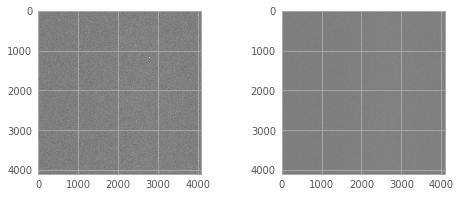

In [38]:
avbias_file=outdir+'averaged_bias.fit' 
avbias_hdul = fits.open(avbias_file)   #Read in bias image
avbias_img = avbias_hdul[0].data

print('Stats')
#Median of med-stacked bias
#Mean of med-stacked bias
#Min of med-stacked bias
#Max of med-stacked bias
print(np.median(avbias_img), avbias_img.mean(), avbias_img.min(), avbias_img.max())


bias_hdul = fits.open(filelist[0])
bias_img = bias_hdul[0].data

fig=plt.figure(figsize=(8,3))
#Plot bias image
ax1=fig.add_subplot(121)
ax1.imshow(bias_img, cmap='gray',vmin=np.median(bias_img)*0.7, vmax=np.median(bias_img)*1.3)
ax2=fig.add_subplot(122)
ax2.imshow(avbias_img, cmap='gray',vmin=np.median(bias_img)*0.7, vmax=np.median(bias_img)*1.3)

In [18]:
#Import Darks
dome1 = fits.open(file_root+"Teng/Darks/dark_30s_1.FIT")
dome2 = fits.open(file_root+"Teng/Darks/dark_30s_2.FIT")

#Extract the image data (usually in extension 0)
dome1d=dark1[0].data
dome2d=dark2[0].data


#Stats of the images
np.median(dome1d), dome1d.mean(), dome1d.min(), dome1d.max()

(1041.0, 1061.753072536204, 986, 60160)

In [14]:
#Analysis
#Make average flat field


#Making this up - in reality you should have a bias frame and a 1s dark frame
bias = 0.1*dome1d
dark = 0.01*dome1d

#Subtract the bias and dark current
dome_1=dome1d-bias-30.*dark
dome_2=dome2d-bias-30.*dark



In [26]:
norm = dome_1/dome_1.mean()
norm.mean()

0.9999999999999997

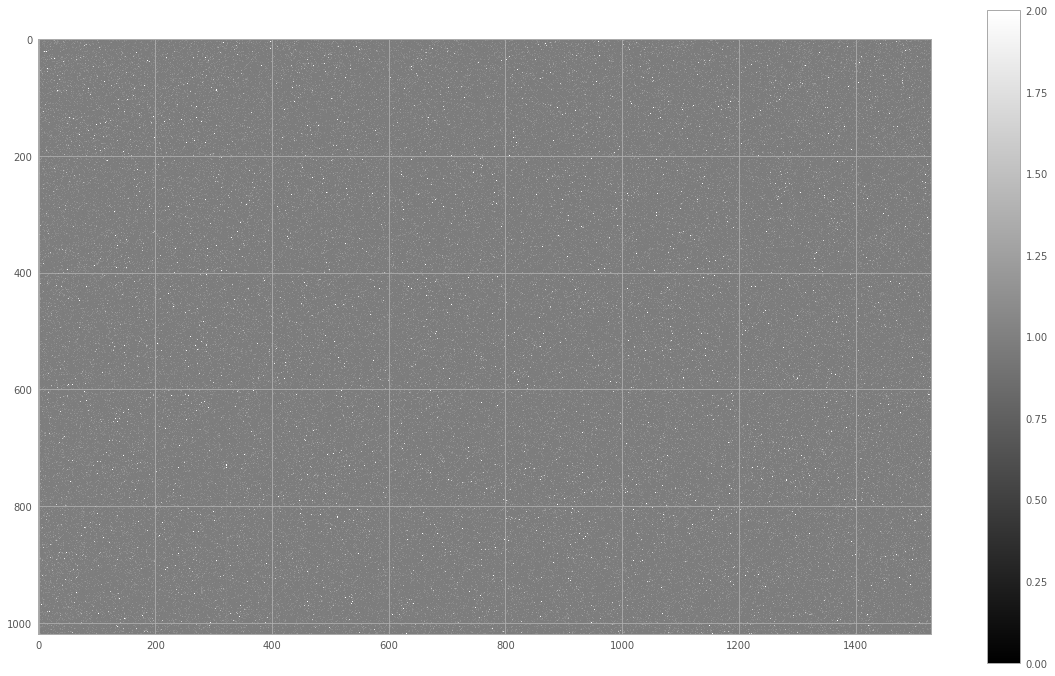

In [27]:
#Visualisation data: 
plt.imshow(norm, cmap='gray', aspect='equal', interpolation='none')
plt.colorbar() 
plt.clim(0,2)
plt.gcf().set_size_inches(20,12)

In [31]:
final=dome_1/norm

#Stats of the images
final.mean(), final.min(), final.max()



(637.0518435217234, 637.0518435217224, 637.0518435217226)

In [ ]:
#Visualisation data: 
plt.imshow(final, cmap='gray', aspect='equal', interpolation='none')
plt.colorbar() 
plt.clim(0,2)
plt.gcf().set_size_inches(20,12)

In [ ]:
#Import Darks
dome1 = fits.open(file_root+"Teng/Darks/dark_30s_1.FIT")
dome2 = fits.open(file_root+"Teng/Darks/dark_30s_2.FIT")


 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   103.0   223.0     14817143
  2   300.0   220.0    461233.37


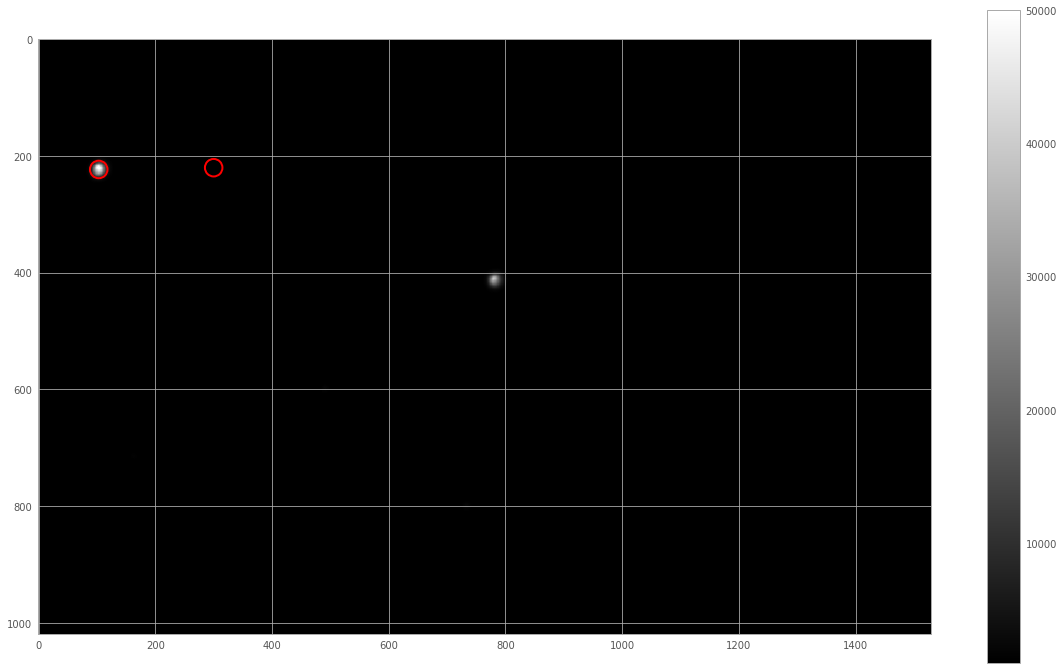

In [23]:
#Import Data

red1= fits.open("RawSBIGImages/ReillyNov2018/M42_30_1.FIT.gz")
red1=red1[0].data.astype(float)



#Set Aperture
positions = [(103., 223.), (300., 220.)] #positions 30,30 and 40,40
apertures = CircularAperture(positions, r=15.)

phot_table = aperture_photometry(red1, apertures)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

#Visualisation data: 
plt.imshow(red1, cmap='gray', aspect='equal', interpolation='none')
plt.colorbar() 
plt.clim(1000,50000)
plt.gcf().set_size_inches(20,12)
apertures.plot(color='red', lw=2)
